In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from scipy.sparse import issparse
import matplotlib.pyplot as plt

In [3]:
# Load the datasets
#na_values =  ? tells pandas to treat any value with a ? as a null.
df_train = pd.read_csv('project_adult.csv', index_col=0, na_values='?')
df_validation = pd.read_csv('project_validation_inputs.csv', index_col=0, na_values='?')

#Seperate columns into numerical and categorical manually
numerical_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_cols = df_train.select_dtypes(include=['object']).columns.drop('income')

In [4]:
# Replace missing values with median for numerical columns
for col in numerical_cols:
    median_value = df_train[col].median()
    df_train[col].fillna(median_value, inplace=True)
    df_validation[col].fillna(median_value, inplace=True)

# Replace missing values with mode (most common entry) for categorical columns
for col in categorical_cols:
    mode_value = df_train[col].mode()[0]
    df_train[col].fillna(mode_value, inplace=True)
    df_validation[col].fillna(mode_value, inplace=True)

In [5]:
# Create a pipeline for categorical features which applies to oen hot encoding
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# 'num' pipeline applies StandardScaler to numerical columns to give them a mean of 0 and variance of 1
# 'cat' pipeline applies the one-hot encoding pipeline to categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [6]:
# Transform income to binary and prepare data
df_train['income'] = df_train['income'].apply(lambda x: 1 if x == '>50K' else 0)
y = df_train['income']
X = df_train.drop('income', axis=1)

In [7]:
# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(X)
X_val_preprocessed = preprocessor.transform(df_validation)

In [8]:
#Confirmation that there are no null values
print("Train Nulls:", pd.DataFrame(X_preprocessed).isnull().sum().sum())
print("Validation Nulls:", pd.DataFrame(X_val_preprocessed).isnull().sum().sum())

Train Nulls: 0
Validation Nulls: 0


In [9]:
# Split data for training and testing
# 30 percent of data will be used for testing 
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.3, random_state=42)
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (18233, 97)
Test data shape: (7815, 97)


Hyperparameter Tuning with GridSearchCV for MLP Candidates

In [10]:
# Define parameter grid for tuning multiple candidates
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],  # single/multi-layer
    'activation': ['relu', 'tanh'], 
    'alpha': [0.0001, 0.001],  # L2 regularization to prevent overfitting
    'learning_rate_init': [0.001, 0.01]  # Initial learning rates
}

# Initialize MLP classifier
mlp = MLPClassifier(max_iter=500, random_state=42, early_stopping=True, validation_fraction=0.1)

# Perform grid search with 3-fold CV
grid_search = GridSearchCV(mlp, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Output best parameters and CV score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validated accuracy: {grid_search.best_score_:.4f}")

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001}
Best cross-validated accuracy: 0.8565


Train Best Model and Predict on Test Set

Test Accuracy: 0.8482
Test Precision: 0.6771
Test Recall: 0.6652
Test F1-Score: 0.6711

Classification Report:

              precision    recall  f1-score   support

       <=50K       0.90      0.90      0.90      5996
        >50K       0.68      0.67      0.67      1819

    accuracy                           0.85      7815
   macro avg       0.79      0.78      0.79      7815
weighted avg       0.85      0.85      0.85      7815



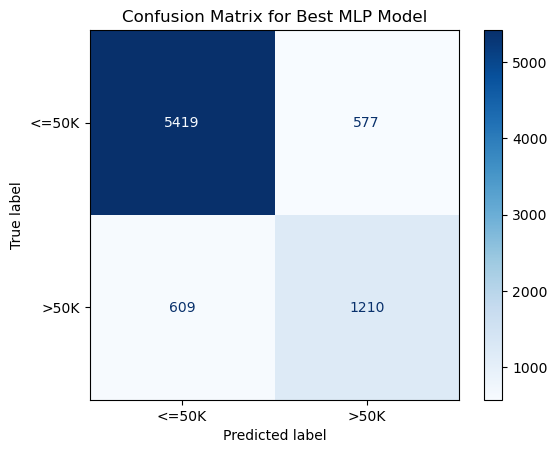

In [11]:
# Select the best model
best_mlp = grid_search.best_estimator_

# Predict on test set
y_pred = best_mlp.predict(X_test)
y_pred_proba = best_mlp.predict_proba(X_test)[:, 1]  # Probabilities for >50K

# Evaluate with metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=0)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")

# Detailed classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=['<=50K', '>50K']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['<=50K', '>50K'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Best MLP Model')
plt.show()

Validation Predictions in Required Format

In [12]:
# Predict on validation set using the best model
val_predictions = best_mlp.predict(X_val_preprocessed)

# Transform to required format: 1 if >50K else -1
val_predictions_transformed = np.where(val_predictions == 1, 1, -1)

# Create DataFrame with predictions
val_results = pd.DataFrame({
    'PredictedOutputs': val_predictions_transformed
}, index=df_validation.index)

# Save to required filename
filename = f"Group_16_MLP_PredictedOutputs.csv"
val_results.to_csv(filename)

print(f"Deliverable saved: {filename}")

Deliverable saved: Group_16_MLP_PredictedOutputs.csv
